# Functional analysis: progeny / dorothea

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import atlas_protocol_scripts as aps
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import decoupler as dc
import itertools
from pathlib import Path
import numpy as np
from scipy import sparse
import seaborn as sns
import urllib.request

from threadpoolctl import threadpool_limits
import multiprocessing

import os

# set PATH env variable to conda env for altair_saver which is looking for npm
os.environ["PATH"] = os.path.dirname(os.environ["_"]) + os.pathsep + os.environ["PATH"]

cpus = 16
os.environ["NUMBA_NUM_THREADS"] = str(cpus)
threadpool_limits(cpus)


import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.filterwarnings("ignore", category=DeprecationWarning) 

warnings.simplefilter(action='ignore')
warnings.filterwarnings('ignore') 


## Configure paths

In [3]:
adata_path = "../../data/input_data_zenodo/atlas-integrated-annotated.h5ad"
results_dir = "../../data/results/10_functional_analysis"

tfnet_file = Path(results_dir, "tf_net_dorothea_hs.tsv")
pwnet_file = Path(results_dir, "pw_net_progeny_hs.tsv")



Create results directory

In [4]:
os.makedirs(results_dir, mode = 0o750, exist_ok = True)

## Load data

### anndata object

In [5]:
adata = sc.read_h5ad(adata_path)

print(f"Anndata has: {adata.shape[0]} cells and {adata.shape[1]} genes")

Anndata has: 62119 cells and 17837 genes


### Progeny and Dorothea data

In [6]:
if Path(tfnet_file).exists():
    tfnet = pd.read_csv(tfnet_file, sep="\t")
else:
    tfnet = dc.get_dorothea(organism='human', levels=['A','B','C'])
    tfnet.to_csv(tfnet_file, sep="\t", index=False)

In [7]:
if Path(pwnet_file).exists():
    pwnet = pd.read_csv(pwnet_file, sep="\t")
else:
    pwnet = dc.get_progeny(organism='human', top=100)
    pwnet.to_csv(pwnet_file, sep="\t", index=False)

## Define contrasts

In [8]:
contrasts = [
    dict(name = "LUSC_vs_LUAD", condition = "LUSC", reference = "LUAD"),
]
contrasts

[{'name': 'LUSC_vs_LUAD', 'condition': 'LUSC', 'reference': 'LUAD'}]

### create result directories for each contrast

In [9]:
for contrast in contrasts:
    res_dir = Path(results_dir, contrast["name"].replace(" ", "_"))
    os.makedirs(res_dir, mode = 0o750, exist_ok = True)
    contrast["res_dir"] = res_dir

### Define cell type class to use

In [10]:
cell_type_class = "cell_type_coarse"

cell_types = adata.obs[cell_type_class].unique()
print(f"Cell types in {cell_type_class} annotation:")
for ct in cell_types:
    print(ct)

Cell types in cell_type_coarse annotation:
B cell
T cell
Epithelial cell
Macrophage/Monocyte
Mast cell
Plasma cell
cDC
Stromal
NK cell
Endothelial cell
pDC
Neutrophils


### Create pseudobulk for each celltype using the coarse cell type annotation

In [11]:
# Store raw rounded counts in layers
adata.layers['int_counts'] = sparse.csr_matrix.ceil(adata.layers['raw_counts'])

In [12]:
# use decoupler to make pseudobulk
pdata = dc.get_pseudobulk(adata,
                          sample_col='sample',
                          groups_col=cell_type_class,
                          layer='int_counts',
                          mode='sum',
                          min_cells=10,
                          min_counts=1000
                         )
# pdata

### Run DESeq2 on pseudobulk of all celltypes from cell_type_class for each contrast

In [13]:
%%capture

# Run deseq2 on pseudobulk all cell types

for contrast in contrasts:
    de_res = {}

    for ct in cell_types:
        print("Working on: " + ct)
        pb_ct = pdata[pdata.obs[cell_type_class] == ct].copy()

        # Build DESeq2 object
        dds = DeseqDataSet(
            adata=pb_ct,
            design_factors='condition',
            refit_cooks=True,
            n_cpus=cpus,
        )

        # Compute LFCs
        dds.deseq2()

        # Extract contrast between LUAD vs LUSC
        stat_res = DeseqStats(dds, contrast=["condition", contrast["condition"], contrast["reference"]], n_cpus=cpus)

        # Compute Wald test
        stat_res.summary()

        # Shrink LFCs
        coeff = "condition_" + contrast["name"]
        stat_res.lfc_shrink(coeff=coeff);

        # Register cell type results
        de_res[ct] = stat_res.results_df
                                             
    # Register results for current contrast
    contrast["de_res"] = de_res


Check if we got a result

In [14]:
contrasts[0]["de_res"]['T cell']

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,574.722839,-0.176134,0.359733,1.968212,0.049044,0.454866
A1BG-AS1,269.177856,-0.306233,0.522962,-1.405101,0.159991,0.675885
A2M,133.317184,-0.516121,0.787432,-2.254733,0.024150,0.340974
A2M-AS1,167.020325,0.168688,0.410052,1.026358,0.304723,0.799727
A2ML1,4.134258,4.955194,1.445137,3.538895,0.000402,0.045308
...,...,...,...,...,...,...
ZXDC,249.252106,-0.365659,0.520643,-1.299807,0.193667,0.705689
ZYG11A,1.356980,0.088777,0.457431,1.341416,0.179785,0.692816
ZYG11B,275.665497,-0.200807,0.416280,-0.725741,0.467997,0.873893
ZYX,1743.302856,0.704401,0.368764,-0.043823,0.965046,0.994016


In [15]:
# Concat and build the stat matrix
for contrast in contrasts:
    stat_mat = (
        pd.concat(
                [
                    res.loc[:, ["stat"]]
                    .rename(columns={"stat": ct})
                    for ct, res in contrast['de_res'].items()
                ],
                axis=1,
                sort=True,
        )
        .fillna(0)
        .T
    )
    contrast['stat_mat'] = stat_mat
    display(stat_mat)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
B cell,0.684423,-0.303548,1.601343,0.209321,0.664652,0.860196,0.000000,-0.625619,-0.074876,0.515725,...,-0.151043,-0.471421,-0.264298,0.212700,-1.551398,-0.791374,2.041125,-1.183747,0.935613,-0.438276
T cell,1.968212,-1.405101,-2.254733,1.026358,3.538895,3.018382,0.469284,-2.452540,-1.928387,1.135368,...,0.001898,-0.104951,0.463285,0.019215,-0.227251,-1.299807,1.341416,-0.725741,-0.043823,-1.022794
Epithelial cell,2.419084,0.526893,-2.169668,-0.217421,1.378207,3.885969,0.000000,-1.369695,-1.373027,-1.606962,...,0.147592,0.470640,1.003928,-1.161040,-1.137526,-1.214502,1.048548,-1.085929,-0.683787,-0.586609
Macrophage/Monocyte,1.887552,-1.810083,-1.159946,-1.056890,-0.089742,3.591771,0.647005,-0.251056,-1.113955,0.923745,...,1.158934,0.456436,1.195565,0.350645,0.693872,-1.945580,1.543994,1.193480,-1.669678,-1.845599
Mast cell,1.302298,-0.146558,-2.031083,0.782389,0.429370,1.451368,0.633780,-0.535325,-1.273304,0.000000,...,-0.398781,0.022905,0.105666,-0.805223,0.682189,0.176131,0.857360,-0.218627,0.142690,-1.842969
Plasma cell,2.342408,-0.843355,0.110927,0.351568,1.257102,1.831766,1.315403,-0.439805,-1.039953,1.386719,...,0.558146,0.771859,0.334057,-0.492667,-0.743263,1.087382,0.858017,1.008448,0.995226,1.844273
cDC,2.915271,-1.574936,-0.613001,-0.024374,0.725753,1.623600,0.597537,1.445475,-0.102699,0.732033,...,0.566662,-0.423151,-0.316143,0.009074,-0.981146,-0.898251,0.607959,0.262559,-2.403562,-1.375922
Stromal,0.137209,-2.405250,-3.248257,-1.364812,0.551220,2.935759,0.909617,-0.946916,-0.540265,1.254717,...,1.032618,0.853582,0.295237,-0.155985,1.581859,0.305391,0.588828,-0.047608,-1.333467,-1.180155
NK cell,1.725606,-1.121034,-0.458949,0.801175,1.437149,1.971736,0.936706,0.059218,-1.618588,1.008651,...,0.860220,0.914887,0.565151,0.838835,-0.497482,-0.509860,1.162220,0.314234,-0.980920,-0.686463
Endothelial cell,-0.253354,1.143024,-1.871821,-1.301253,0.838570,2.534586,0.000000,-0.732096,2.002085,0.245973,...,1.058090,1.103358,-1.199881,0.083750,1.584533,-1.167762,0.801459,0.589046,0.517857,-2.129528


In [126]:
# Concat and build the log2FoldChange change matrix
for contrast in contrasts:
    lfc_mat = (
        pd.concat(
                [
                    res.loc[:, ["log2FoldChange"]]
                    .rename(columns={"log2FoldChange": ct})
                    for ct, res in contrast['de_res'].items()
                ],
                axis=1,
                sort=True,
        )
        .fillna(0)
        .T
    )
    contrast['lfc_mat'] = lfc_mat
    display(lfc_mat)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
B cell,-0.050075,-0.029608,0.107442,-0.008182,0.030349,0.069655,0.000000,-0.034181,-0.114723,-0.002413,...,-0.014026,-0.055829,0.013303,0.014711,-0.120881,-0.055596,0.152655,-0.075667,0.143717,-0.046722
T cell,-0.176134,-0.306233,-0.516121,0.168688,4.955194,3.943391,-0.010236,-0.126971,-0.509794,0.059693,...,-0.042313,-0.096330,0.284333,-0.096000,-0.104836,-0.365659,0.088777,-0.200807,0.704401,-0.269536
Epithelial cell,1.842792,0.101191,-0.172776,-0.043376,0.835244,2.265260,-0.017525,0.113850,0.073271,-0.141242,...,0.301966,0.181286,0.843679,-0.142398,-0.049925,0.125832,0.163727,0.161626,0.302486,0.140345
Macrophage/Monocyte,0.398192,-0.129409,0.532462,-0.093795,-0.036024,1.440810,-0.030489,-0.070088,-0.123911,0.005782,...,0.143016,0.055544,0.136485,0.032148,0.090580,-0.652206,-0.018842,0.174589,0.653545,-0.480450
Mast cell,0.333324,-0.006925,-0.728778,0.159155,-0.016608,0.191880,-0.008330,-0.147947,-0.286807,0.000000,...,-0.067005,-0.001955,0.046712,-0.091440,0.129229,0.042689,0.102795,-0.052988,-0.032493,-0.489094
Plasma cell,0.872826,-0.169202,0.019061,-0.061040,-0.007106,0.259509,-0.005032,-0.140949,-0.343237,0.102643,...,0.099462,-0.097551,-0.051277,-0.138453,-0.171635,0.253790,0.119066,0.259797,0.265545,0.645213
cDC,1.357507,-0.385448,0.304102,-0.018509,0.101984,0.524045,-0.017593,0.576517,-0.063763,-0.008589,...,0.189360,-0.137678,-0.069565,0.055737,-0.264336,-0.327283,-0.016775,0.061484,-0.745995,-0.583541
Stromal,0.172957,-0.393430,0.394126,-0.336424,-0.030632,1.972672,-0.003656,-0.210503,-0.217116,0.087181,...,-0.006061,0.302650,0.028192,0.001515,0.722223,0.228919,-0.018026,-0.067010,0.474587,-0.445948
NK cell,0.450865,-0.088905,-0.066775,0.124303,0.103413,0.134282,-0.005210,-0.013442,-0.273099,-0.000695,...,0.134603,0.172240,-0.063325,-0.096136,-0.150896,-0.077764,0.081218,0.042082,-0.315329,-0.158347
Endothelial cell,-0.023559,0.149000,0.616389,-0.128171,-0.004235,0.989147,0.000000,-0.074912,0.525662,0.007666,...,0.168906,0.150973,-0.057908,0.006735,0.310443,-0.086350,-0.004639,0.144971,0.653229,-0.604508


In [127]:
# Concat and build the fdr
for contrast in contrasts:
    fdr_mat = (
        pd.concat(
                [
                    res.loc[:, ["padj"]]
                    .rename(columns={"padj": ct})
                    for ct, res in contrast['de_res'].items()
                ],
                axis=1,
                sort=True,
        )
        .fillna(1)
        .T
    )
    contrast['fdr_mat'] = fdr_mat
    display(fdr_mat)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
B cell,0.999812,0.999812,0.999812,0.999812,0.999812,0.999812,1.000000,0.999812,0.999812,0.999812,...,0.999812,0.999812,0.999812,0.999812,0.999812,0.999812,0.999812,0.999812,0.999812,0.999812
T cell,0.454866,0.675885,0.340974,0.799727,0.045308,0.122616,1.000000,0.277414,0.471055,0.763513,...,0.999854,0.986585,0.936039,0.997080,0.966952,0.705689,0.692816,0.873893,0.994016,0.800670
Epithelial cell,0.204775,0.866294,0.277238,1.000000,0.568813,0.014306,1.000000,0.572048,0.570431,0.487676,...,0.969352,0.881925,0.711276,0.658611,0.665697,0.636127,0.694796,0.680435,0.822788,0.849618
Macrophage/Monocyte,1.000000,1.000000,0.472222,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.270869,1.000000
Mast cell,0.746989,1.000000,1.000000,0.897769,1.000000,1.000000,1.000000,0.937806,0.759048,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984503,1.000000
Plasma cell,0.134526,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
cDC,0.535434,0.980838,0.980838,0.998036,0.980838,0.980838,0.980838,0.980838,0.992341,0.980838,...,0.980838,0.980838,0.984013,0.999031,0.980838,0.980838,0.980838,0.984709,0.733859,0.980838
Stromal,0.986890,0.834538,0.413162,0.981708,0.981708,0.562765,0.981708,0.981708,0.981708,0.981708,...,0.981708,0.981708,0.983063,0.986890,0.981708,0.983063,0.981708,0.994226,0.981708,0.981708
NK cell,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Endothelial cell,0.988562,0.960442,0.790034,0.927155,1.000000,0.534561,1.000000,0.988321,0.745843,0.988562,...,0.974102,0.965274,0.946266,0.993431,0.865033,0.951033,1.000000,0.988321,0.988321,0.714502


### Infer pathway activities with consensus

In [16]:
# Infer pathway activities with consensus
for contrast in contrasts:
    print(contrast['name'])
    pathway_acts, pathway_pvals = dc.run_consensus(mat=contrast['stat_mat'], net=pwnet)
    contrast['pathway_acts'] = pathway_acts
    contrast['pathway_pvals'] = pathway_pvals
    display(pathway_acts)

LUSC_vs_LUAD


,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
B cell,0.062939,-0.910739,-1.038329,-1.624462,0.507894,-0.351957,-0.602665,-0.378580,0.858945,0.321914,0.623660,-1.260204,-0.758539,1.988513
T cell,-0.223223,-0.729068,-0.702562,-1.049729,-2.374628,-0.569556,-0.519256,-0.246436,-0.271419,0.419378,0.666087,-0.943721,0.681331,1.493188
Epithelial cell,-0.303212,-0.303766,-0.368689,0.526601,-0.380728,-1.082579,-1.459781,-0.261235,-1.110388,-2.071201,1.249942,-0.056985,-0.302893,0.987254
Macrophage/Monocyte,-0.482002,-1.010177,-0.327329,-1.336789,-0.582139,-0.909175,-2.019901,-0.128961,-0.356757,-0.730278,0.271995,-0.331442,1.045610,1.216933
Mast cell,-0.558213,-1.169621,1.020281,-0.310194,-1.397407,-1.258175,-1.358884,-0.892186,-0.138127,-0.991052,0.665459,-0.356392,0.888819,1.105882
Plasma cell,0.469449,-1.031615,0.627337,-0.701767,-1.576447,-0.047319,-1.074090,0.449529,1.688283,-0.700847,0.954997,-0.392691,1.030743,1.051407
cDC,-0.134425,-0.613303,-0.327458,-0.409282,-1.827826,-0.578036,-1.957997,-0.171727,-0.405335,-1.117040,0.361363,-0.362108,1.299557,0.824627
Stromal,-0.354937,-0.243664,0.156538,-1.626976,-0.154900,0.430590,1.072540,-0.268128,-1.403998,-0.527387,1.749872,-1.474300,0.554584,0.759733
NK cell,-0.183768,-0.484799,-0.325389,-1.181857,-2.436950,-0.672178,-0.374020,-0.207960,1.151950,0.274978,0.427968,-0.338431,1.628383,0.340598
Endothelial cell,0.129955,0.194947,0.630472,-0.382399,-1.737014,0.313977,2.064026,0.598129,-0.733381,0.458351,1.758808,-0.049834,0.192832,0.439736


### Generate per cell type pathway activity barplots

LUSC_vs_LUAD


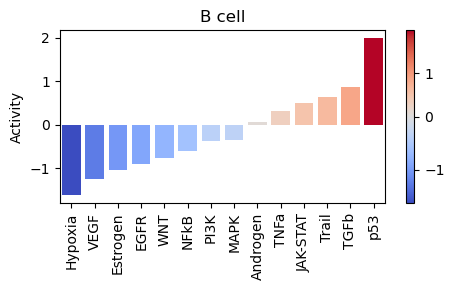

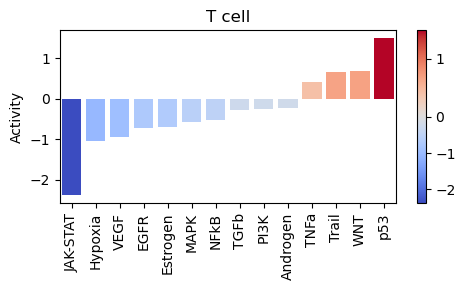

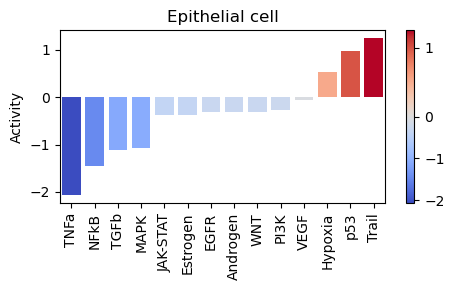

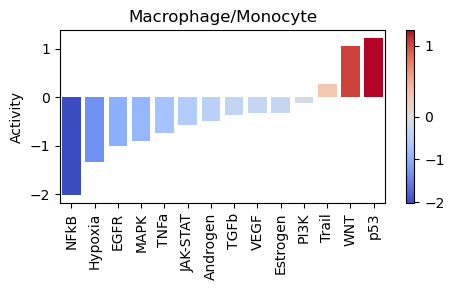

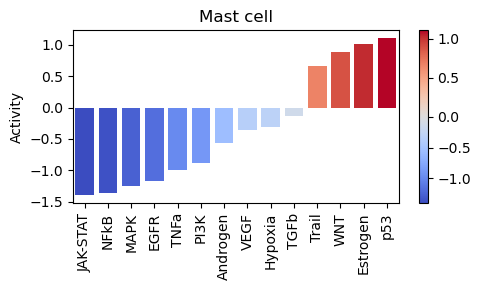

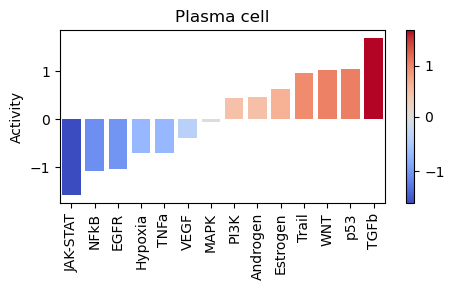

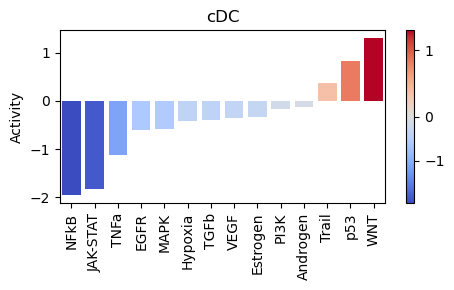

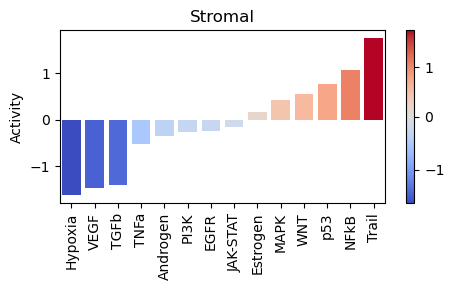

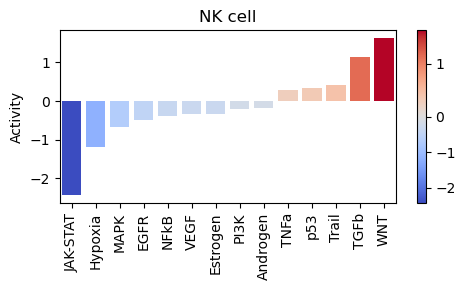

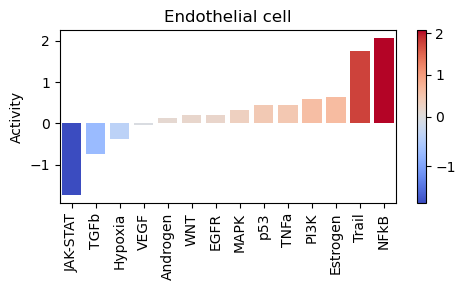

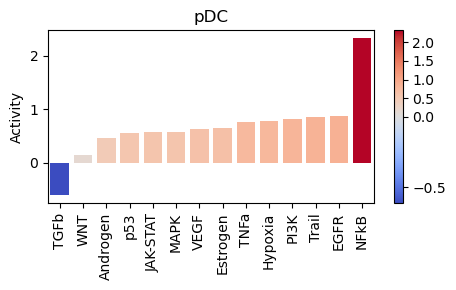

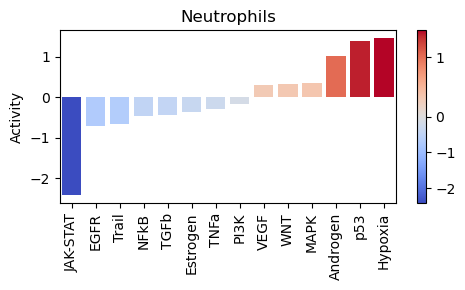

In [17]:
for contrast in contrasts:
    print(contrast['name'])
    for ct in cell_types:
        bp = dc.plot_barplot(contrast['pathway_acts'], ct, top=25, vertical=False, return_fig=True, figsize=[5,3])
        plt.title(ct)
        plt.tight_layout()
        
        if bp is not None:
            ct_fname = ct.replace(" ", "_").replace("/", "_")
            aps.pl.save_fig_mfmt(bp, 
                             res_dir=f"{contrast['res_dir']}/pathways/", 
                             filename=f"{contrast['name']}_pw_acts_barplot_{ct_fname}", 
                             fmt="all",
                             plot_provider="mpl")
        else:
            print("No plot for: " + contrast["name"] + ":" + ct)
        

### Generate pathway activity heatmap

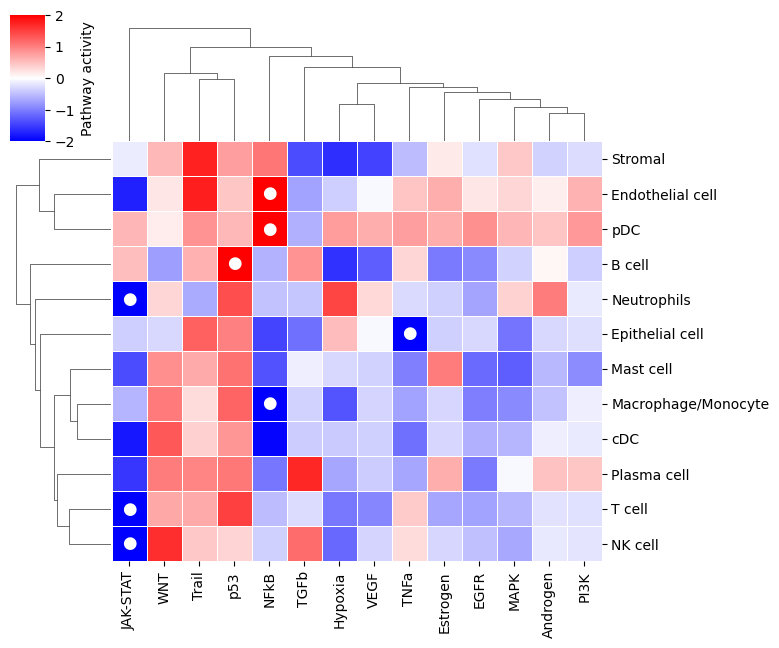

In [18]:
# generate heatmap plot
for contrast in contrasts:
    
    # mark significant activities
    sig_mat = np.where(contrast['pathway_pvals'] < 0.05, "●", "")
    
    with plt.rc_context({"figure.figsize": (5.2, 5)}):
        chm = sns.clustermap(
            contrast['pathway_acts'], 
            annot=sig_mat,
            annot_kws={'fontsize': 12},
            center=0, 
            cmap='bwr', 
            linewidth=0.5, 
            cbar_kws={"label": "Pathway activity"},
            vmin=-2,
            vmax=2, 
            fmt="s",
            figsize=(7,7)
        )
        aps.pl.reshape_clustermap(chm, cell_width=0.05, cell_height=0.05)
        aps.pl.save_fig_mfmt(chm, res_dir=f"{contrast['res_dir']}/pathways/", filename=f"{contrast['name']}_pw_acts_heatmap", fmt="all", plot_provider="mpl")
        plt.show()

### Generate target gene expression plots for significant pathways

Get significant pathways

In [19]:
# filter for p-value < 0.05
for contrast in contrasts:
    p = contrast['pathway_pvals']
    sig_pathways_idx = np.where(p < 0.05)

    # make list of celltype / pathway pairs
    sig_pathways = list()

    for sig_pw in list(zip(sig_pathways_idx[0], sig_pathways_idx[1])):
        ct = p.index[sig_pw[0]]
        pw = p.columns[sig_pw[1]]
        sig_pathways.append({'ct': ct, 'pw': pw})

    contrast['sig_pathways'] = sig_pathways

Generate plot

LUSC_vs_LUAD


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

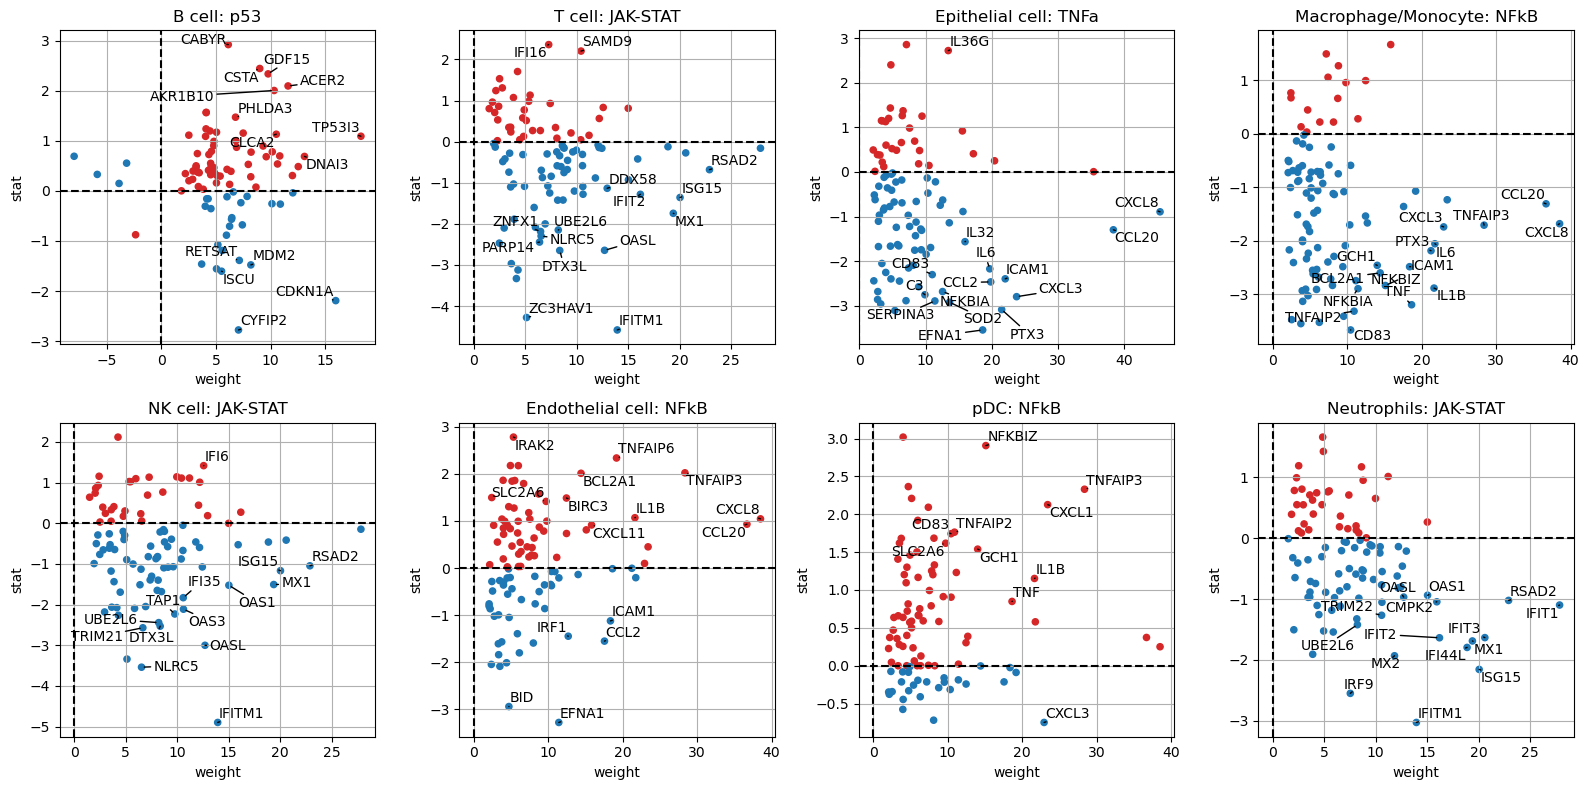

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


In [24]:
for contrast in contrasts:
    print(contrast["name"])
    sig_pw = contrast['sig_pathways']
    
    # Calculate nrows based on ncol
    n_sig = len(sig_pw)
    ncols = 4 if n_sig >= 4 else n_sig
    nrows = int(np.ceil(n_sig / ncols))

    # Initialize the figure panel
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4))
    axs = {": ".join(sig_pw.values()): {'ax': ax, 'sig_pw': sig_pw} for sig_pw, ax in zip(sig_pathways, axs.flatten())}

    # Run dc.plot_targets for all significant celltype/pathway combinations using the stat values from deseq2
    for key, ax_sig_pw in axs.items():
        dc.plot_targets(
            de_res[ax_sig_pw['sig_pw']['ct']],
            stat='stat',
            source_name=ax_sig_pw['sig_pw']['pw'], 
            net=pwnet,
            top=15, 
            return_fig=False,
            ax=ax_sig_pw['ax']
        )
        ax_sig_pw['ax'].set_title(key)
    plt.tight_layout()
    plt.show()

    # Save figure
    aps.pl.save_fig_mfmt(fig, res_dir=f"{contrast['res_dir']}/pathways/", filename=f"{contrast['name']}_pw_target_expression", fmt="all", plot_provider="mpl")


### Save pathway activity and p-values matrix

In [21]:
# save tsv
for contrast in contrasts:
    tsv_dir = Path(contrast['res_dir'], "pathways", "tsv")
    os.makedirs(tsv_dir, mode = 0o750, exist_ok = True)
    contrast['pathway_acts'].to_csv(f"{tsv_dir}/{contrast['name']}_pathway_acts.tsv", sep="\t")
    contrast['pathway_pvals'].to_csv(f"{tsv_dir}/{contrast['name']}_pathway_pvals.tsv", sep="\t")


### Infer transcription factor activities with consensus

In [25]:
# Infer transcription factor activities with consensus
for contrast in contrasts:
    print(contrast['name'])
        
    tf_acts, tf_pvals = dc.run_consensus(mat=contrast['stat_mat'], net=tfnet)
    contrast['tf_acts'] = tf_acts
    contrast['tf_pvals'] = tf_pvals
    display(tf_acts)

LUSC_vs_LUAD


,AHR,AR,ARID2,ARID3A,ARNT,ASCL1,ATF1,ATF2,ATF3,ATF4,...,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF584,ZNF592,ZNF639,ZNF644,ZNF740
B cell,0.375466,-0.014985,-1.519568,-1.912114,0.222357,1.075886,-0.031306,-0.134155,-0.335286,-0.554043,...,-0.284815,0.312398,-0.087596,-1.166524,-1.089032,-0.947744,-0.973095,-1.934187,-0.513126,-1.061236
T cell,-0.127949,0.201533,-0.852365,-0.529944,-0.235877,1.481737,-0.500058,0.095640,-0.966793,-0.971196,...,-0.885897,-0.301472,0.106797,-1.372497,-1.874036,-1.619472,-0.794048,-0.932547,-0.063943,-0.730681
Epithelial cell,-1.162514,-1.156974,-0.614183,0.831332,-0.612767,-0.227965,-0.526837,-0.501946,-1.643791,-1.406460,...,-0.561578,-0.277035,-0.598650,-1.319268,-1.427962,-0.431309,-0.094037,-0.626485,-0.915031,-0.075844
Macrophage/Monocyte,-0.677118,-0.001266,-0.964436,-0.399426,-0.359183,-0.189252,-0.380906,-0.577122,-1.273536,-0.787079,...,-0.948576,-0.597313,-1.558347,-1.057714,-1.551499,-0.651860,-0.401245,-0.460925,-0.664587,-0.780933
Mast cell,-0.907898,0.583647,-1.167744,-0.116214,-0.078232,0.703708,-1.008967,-1.143528,-2.069365,-1.509866,...,-0.392816,-0.723960,0.236709,-1.566490,-0.911582,-2.364721,-0.072142,-1.615885,0.086767,-1.133741
Plasma cell,0.346374,-0.472364,-1.035604,-0.730537,-0.032283,1.539520,-0.500459,-1.294848,-1.425769,-1.915199,...,0.021258,0.157674,1.363989,-0.570431,-1.023030,-1.033195,-0.853295,-0.667802,-0.731044,-0.108057
cDC,-0.579521,-0.429273,-0.746707,-0.161063,-0.165741,-0.064079,-1.185623,-1.000612,-0.911983,-0.732977,...,-0.704621,-0.522162,-1.285082,-0.862702,-1.263959,-0.433364,-0.691978,-0.653625,-0.218683,-0.677661
Stromal,-0.251816,-1.009420,0.396246,1.496195,-0.869898,0.611756,-0.705534,-0.062573,-0.703112,-0.453317,...,0.466599,0.119462,0.100236,-1.663489,-1.145490,-0.885577,-0.542012,-0.028534,0.060021,0.903513
NK cell,0.241436,-0.001538,-1.114008,-0.250808,-0.685712,0.027966,-0.857630,-0.159990,-0.578676,-0.535351,...,-0.762266,0.514372,0.986268,-0.926773,-1.214987,-1.325734,-1.005137,-1.269667,-0.616160,-0.763273
Endothelial cell,0.939792,-0.221866,0.405206,0.796921,0.319288,0.684817,-0.328915,0.352279,-0.537024,-1.889514,...,1.234484,-0.080275,0.271844,-0.825655,-0.553385,-1.815532,-0.230609,0.490492,-0.053382,-0.534089


### Generate per cell type transcription factor activity barplots

LUSC_vs_LUAD


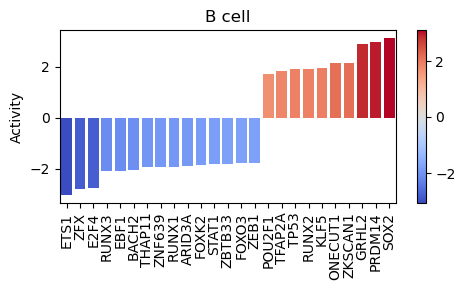

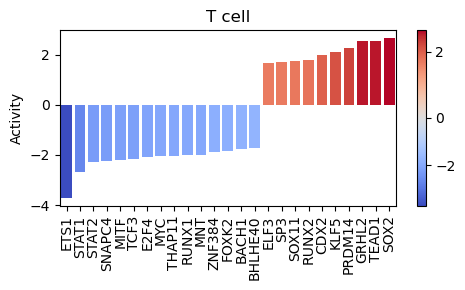

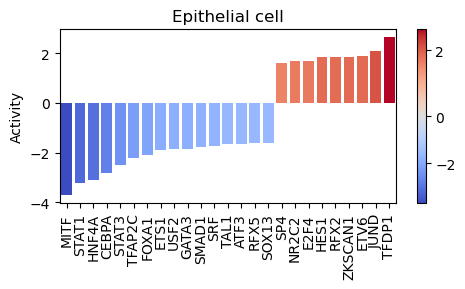

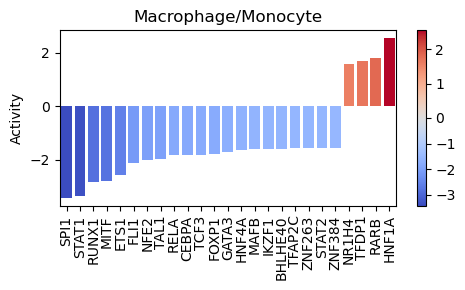

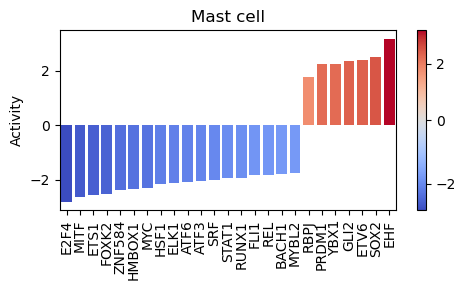

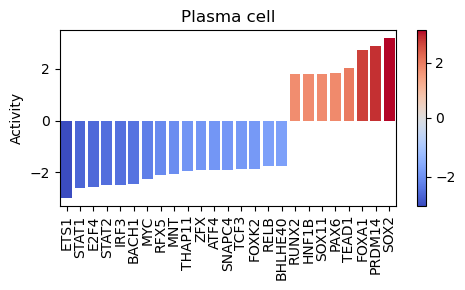

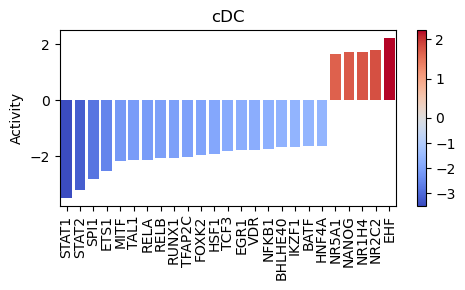

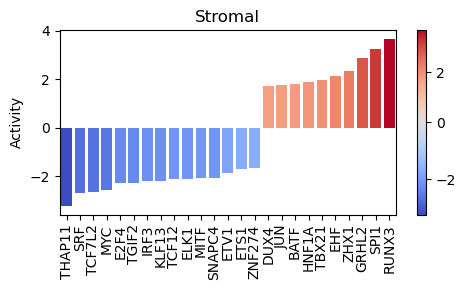

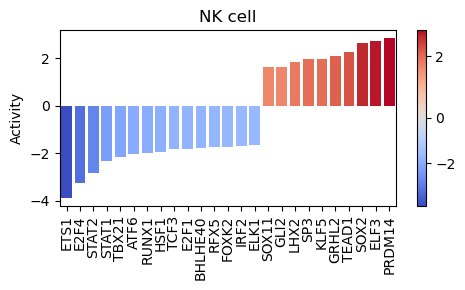

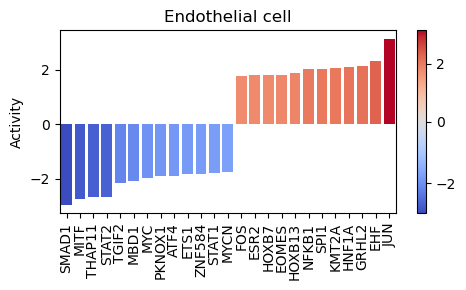

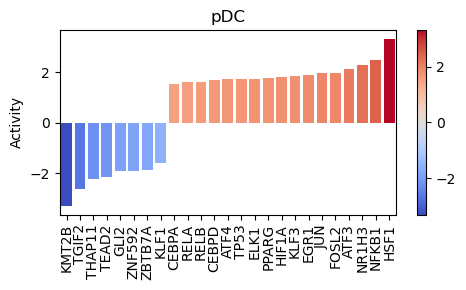

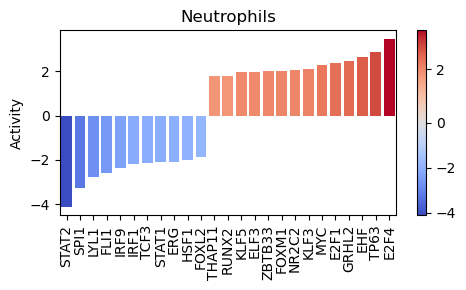

In [60]:
for contrast in contrasts:
    print(contrast['name'])
    for ct in cell_types:
        bp = dc.plot_barplot(contrast['tf_acts'], ct, top=25, vertical=False, return_fig=True, figsize=[5,3])
        plt.title(ct)
        plt.tight_layout()
        
        if bp is not None:
            ct_fname = ct.replace(" ", "_").replace("/", "_")
            aps.pl.save_fig_mfmt(bp, 
                             res_dir=f"{contrast['res_dir']}/transcription_factors/", 
                             filename=f"{contrast['name']}_tf_acts_barplot_{ct_fname}", 
                             fmt="all",
                             plot_provider="mpl")
        else:
            print("No plot for: " + contrast["name"] + ":" + ct)
        

### Generate transcription factor activity heatmap

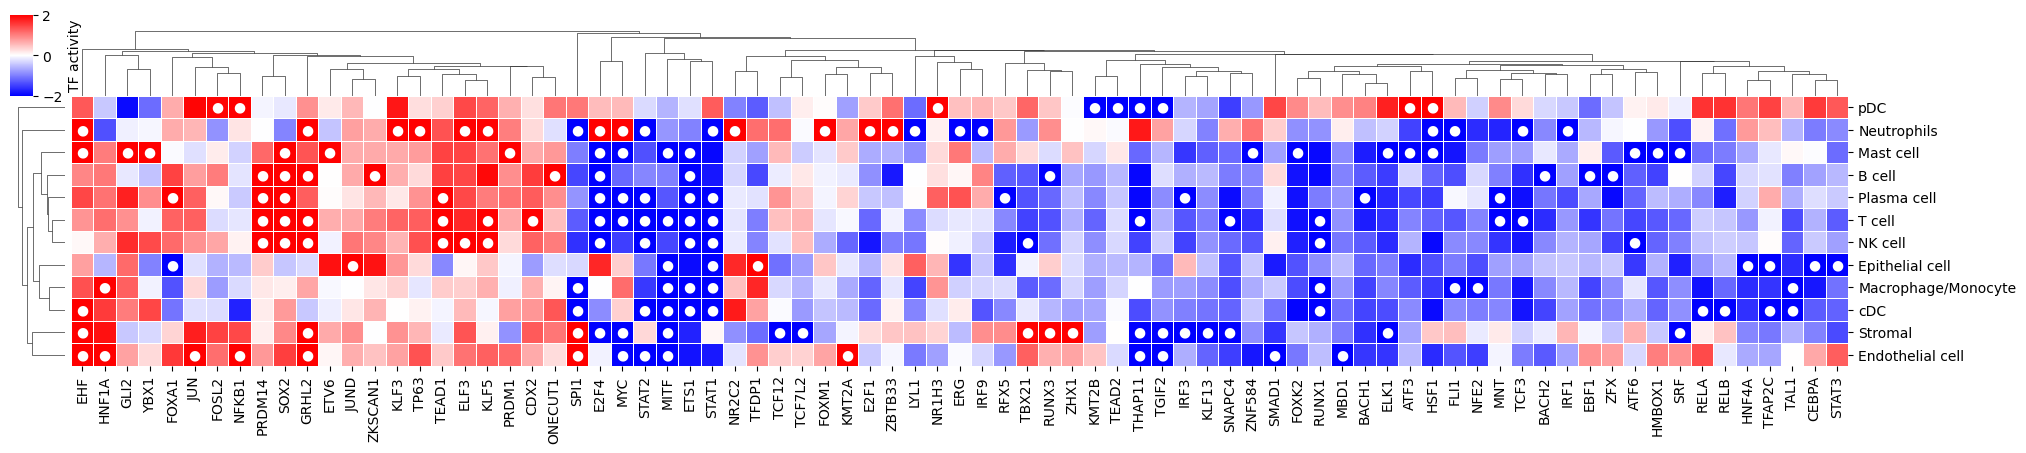

In [97]:
# generate heatmap plot
for contrast in contrasts:
    
    # get acts and pvals
    pvals = contrast['tf_pvals']
    acts = contrast['tf_acts']
    
    # select the columns that have significant acts (pval < 0.05)
    sig_pval_cols = pvals.columns[(pvals < 0.05).any()]

    pvals = pvals[sig_pval_cols]
    acts = acts[sig_pval_cols]
    
    # mark significant activities
    sig_mat = np.where(pvals < 0.05, "●", "")
    
    with plt.rc_context({"figure.figsize": (10, 5)}):
        chm = sns.clustermap(
            acts, 
            annot=sig_mat,
            annot_kws={'fontsize': 10},
            center=0, 
            cmap='bwr', 
            linewidth=0.5, 
            cbar_kws={"label": "TF activity"},
            vmin=-2,
            vmax=2, 
            fmt="s",
            xticklabels=True,
            figsize=(4.5,4.5)
        )
        aps.pl.reshape_clustermap(chm, cell_width=0.05, cell_height=0.05)
        aps.pl.save_fig_mfmt(chm, res_dir=f"{contrast['res_dir']}/transcription_factors/", filename=f"{contrast['name']}_tf_acts_heatmap", fmt="all", plot_provider="mpl")
        plt.tight_layout()
        plt.show()

### Volcano plots of expression of target genes from transcription factors of interest

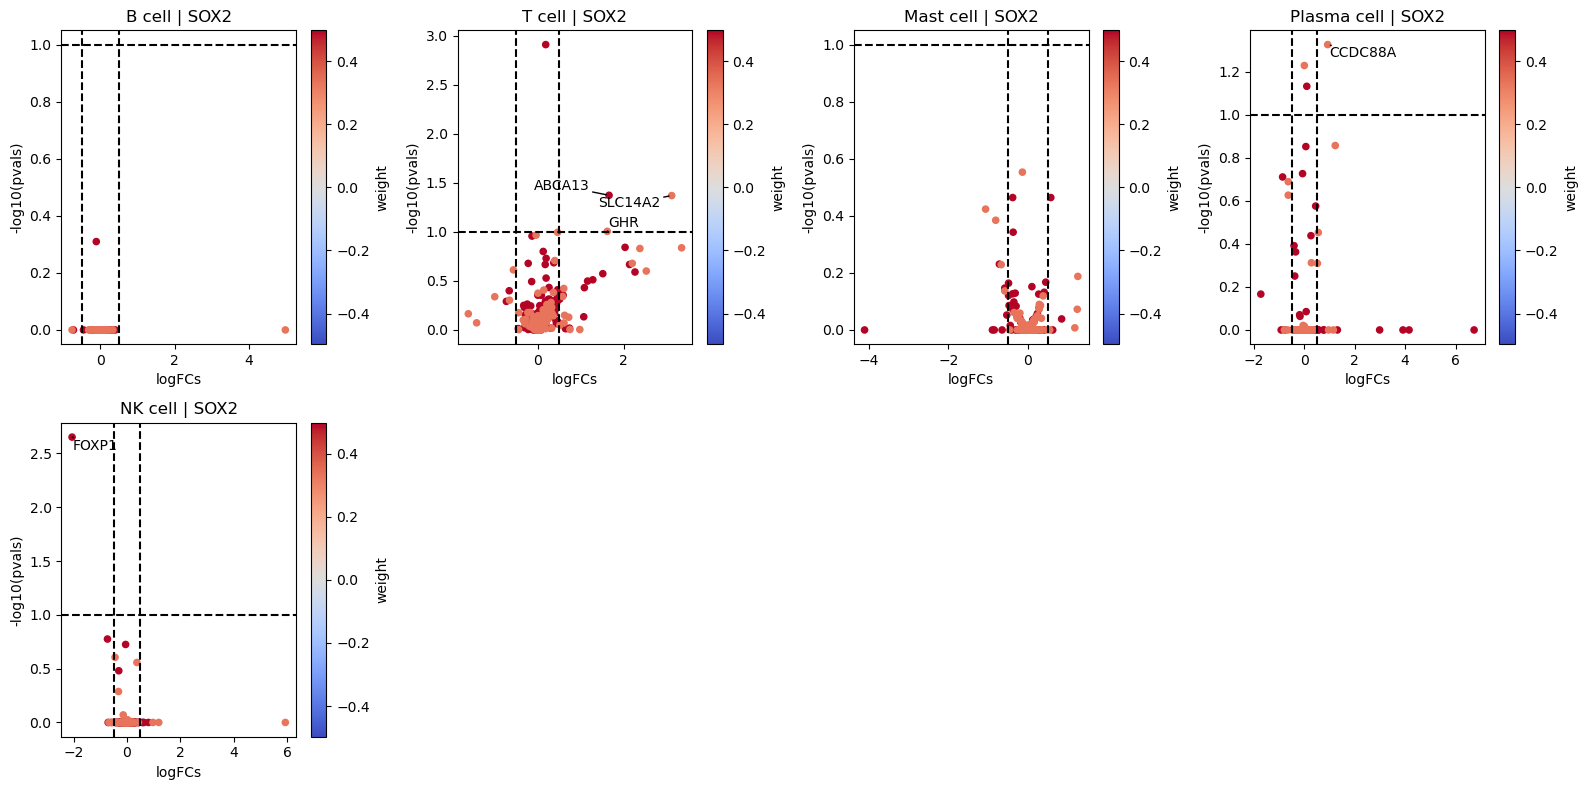

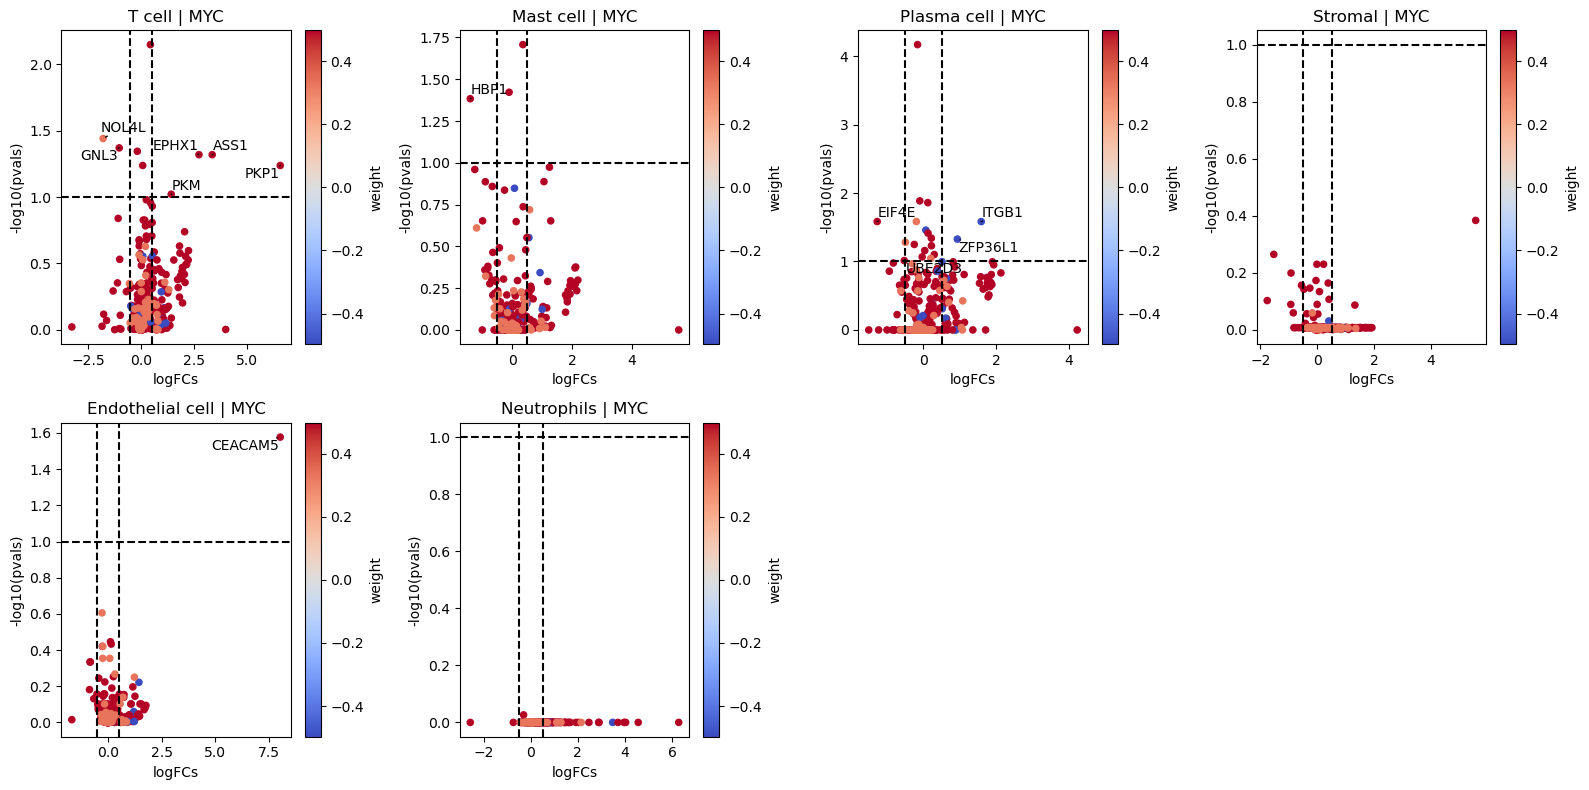

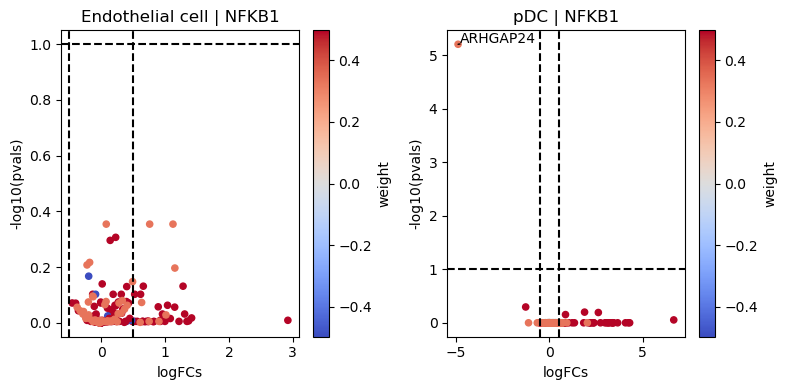

In [186]:
# Define transcription factors of interest
tf_of_interest = ["NFKB1", "SOX2", "MYC"]

for contrast in contrasts:
    # Extract logFCs and pvals
    logFCs = contrast['lfc_mat']
    pvals = contrast['fdr_mat']
    tf_pvals = contrast['tf_pvals']

    # get sig ct for tfoi
    n_sig = 0
    sig_tf = {}
    for ct in cell_types:
        for tfoi in tf_of_interest:
            if tf_pvals.loc[ct][tfoi] < 0.05:
                if tfoi not in sig_tf:
                    sig_tf[tfoi]= list()
                sig_tf[tfoi].append( { "ct": ct, "tf": tfoi} )
                n_sig += 1


    # generate a volcano plot panel for each transcription factor of interest:
    # the panels show volcano plots for each celltype in which there is a
    # signigicant transcription factor activity
    for tf in sig_tf.keys():
        n_sig = len(sig_tf[tf])
        
        # Calculate nrows based on ncol
        ncols = 4 if n_sig >= 4 else n_sig
        nrows = int(np.ceil(n_sig / ncols))

        # Initialize the figure panel
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4))
        empty_axs = axs.flatten()
        axs = [ {'ct_tf': ct_tf, 'ax': ax} for ct_tf, ax in zip(sig_tf[tf], axs.flatten()) ]

        for ax in axs:
            dc.plot_volcano(
                logFCs, 
                pvals, 
                ax["ct_tf"]['ct'], 
                name=ax["ct_tf"]['tf'], 
                net=tfnet, 
                top=10, 
                sign_thr=0.1, 
                lFCs_thr=0.5,
                return_fig=False,
                ax=ax['ax']
            )
            
        # set empty axes invisible
        for ax in range(len(axs), len(empty_axs)):
            empty_axs[ax].set_visible(False)

        plt.tight_layout()
        plt.show()

        # Save figure
        aps.pl.save_fig_mfmt(fig, res_dir=f"{contrast['res_dir']}/transcription_factors/", filename=f"{contrast['name']}_{tf}_target_expression", fmt="all", plot_provider="mpl")